In [1]:
# Cosmic Web Analysis: Spectroscopic vs Photometric Comparison
# Team:Jenna Shuffelton, Valeria Lopez, Celine Mayer
# Question: Does the spectroscopic sample miss cosmic structures due to selection bias?
# We want: Compare SDSS spectroscopic and photometric galaxy samples to investigate
# whether selection bias causes us to miss large-scale structures (filaments, voids, clusters)

In [2]:
## Our Sky Region (values in the proposal!)

#RA:180 to 185 (5 degree width) -- degrees
#Dec: 30 to 35 (5 degree height) -- degrees
#Redshift 0.02 < z < 0.30

In [ ]:
!pip install astroquery
!pip install astro-datalab

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dl import queryClient as qc
from astropy.cosmology import Planck18 as cosmo
from astroquery.sdss import SDSS

import warnings
warnings.filterwarnings('ignore',module='astropy.io.votables.tree')
warnings.filterwarnings('ignore',message='.*unclosed..socket')

In [2]:
#region parameters
ra_min = 180.0
ra_max = 185.0
dec_min = 30.0
dec_max = 35.0
z_min = 0.02
z_max = 0.30

print(f"RA range:  {ra_min} to {ra_max} degrees (width: {ra_max - ra_min} degrees)")
print(f"Dec range: {dec_min} to {dec_max} degrees (height: {dec_max - dec_min} degrees)")
print(f"Redshift:  {z_min} to {z_max}\n")
print(f"Sky area: {(ra_max - ra_min) * (dec_max - dec_min)} square degrees")

RA range:  180.0 to 185.0 degrees (width: 5.0 degrees)
Dec range: 30.0 to 35.0 degrees (height: 5.0 degrees)
Redshift:  0.02 to 0.3

Sky area: 25.0 square degrees


In [ ]:
#Spectroscopic Data Collection
#Jenna, I think you wanted to work on this?
## Query SDSS DR17 specObj table to get galaxies w their accurate spectroscopic redshifts
##git has the examples for this, but we are using astroquery

## i did some research and for this section we need this -- feel free to delete or add if i missed something:

#1. Query SDSS spectroscopic catalog
#2. Filter for galaxies in our sky region
#3. Remove bad redshifts
#4. Save data to CSV
#5. Create basic plots

In [ ]:
# like in the git, test query with limit 100
print("Galaxies retrieved", len(spec_data_test))
print("First 5 entries")
print(spec_data_test.head())

Galaxies retrieved 2415
First 5 entries
          ra        dec         z      zerr   class            specobjid
0  180.40698  30.003892  0.164183  0.000035  GALAXY  2505266993263831040
1  180.49896  30.004638  0.071869  0.000020  GALAXY  2508591093285677056
2  180.75047  30.007559  0.127590  0.000024  GALAXY  2505277988380108800
3  181.10918  30.004950  0.079258  0.000033  GALAXY  2508579548413585408
4  180.07069  30.035298  0.151829  0.000019  GALAXY  2505264519362668544


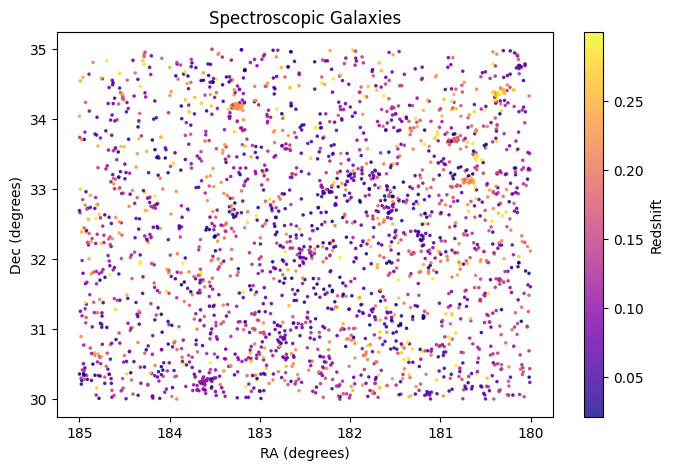

In [10]:
# Simple visualization of test data

plt.figure(figsize=(8, 5))
plt.scatter(spec_data_test['ra'],spec_data_test['dec'],c=spec_data_test['z'], s=2.5, alpha=0.8, cmap='plasma')

plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('Spectroscopic Galaxies')
plt.colorbar(label='Redshift')
plt.gca().invert_xaxis()
plt.show()

In [11]:
#Photometric Query
query_photo = f"""
SELECT
    l.ra,
    l.dec,
    l.type,
    l.ls_id,
    l.mag_r,
    l.mag_g,
    l.mag_z,
    l.mag_i,
    l.shape_r,
    l.sersic
FROM ls_dr10.tractor AS l
WHERE
    l.ra BETWEEN {ra_min} AND {ra_max}
    AND l.dec BETWEEN {dec_min} AND {dec_max}
    AND l.type != 'PSF'  -- exclude stars
    AND l.mag_r < 22.0
    AND l.mag_r > 14.0
LIMIT 10000
"""

print("Photometric query ready.")
print(f"Run with: photo_data = qc.query(sql=query_photo, fmt='pandas')")

Photometric query ready.
Run with: photo_data = qc.query(sql=query_photo, fmt='pandas')


In [12]:
# like in the git, test query with limit 100
photo_data = qc.query(sql=query_photo, fmt='pandas')
print(f"Photometric galaxies retrieved: {len(photo_data)}")
print("First 5 entries:")
print(photo_data.head())

Photometric galaxies retrieved: 10000
First 5 entries:
           ra        dec type              ls_id      mag_r      mag_g  \
0  180.020120  30.000292  EXP  10995636693369212  21.827425  22.593670   
1  180.007851  30.003517  DEV  10995636693368995  18.240868  19.341526   
2  180.039613  30.002668  DEV  10995636693369582  18.160702  19.086380   
3  180.033216  30.010361  REX  10995636693369453  21.867355  23.330849   
4  180.035501  30.007932  REX  10995636693369499  20.480803  21.929708   

       mag_z      mag_i   shape_r  sersic  
0  21.481842  21.596865  0.633300     1.0  
1  17.561504  17.865276  1.061211     4.0  
2  17.509697  17.787430  3.598927     4.0  
3  20.574919  21.077847  0.481297     1.0  
4  19.639025  19.997984  0.331723     1.0  


In [14]:
query_crossmatch = f"""
SELECT
    l.ra AS photo_ra,
    l.dec AS photo_dec,
    l.type,
    l.ls_id,
    l.mag_r,
    l.mag_g,
    l.mag_z,
    l.mag_i,
    l.shape_r,
    l.sersic,
    l.g_r,  -- pre-computed color
    l.r_z,  -- pre-computed color
    s.ra AS spec_ra,
    s.dec AS spec_dec,
    s.z AS redshift,
    s.zerr AS redshift_err,
    s.class,
    s.specobjid
FROM ls_dr10.tractor AS l
JOIN ls_dr10.x1p5__tractor__sdss_dr17__specobj AS x ON l.ls_id = x.id1
JOIN sdss_dr17.specobj AS s ON x.id2 = s.specobjid
WHERE
    l.ra BETWEEN {ra_min} AND {ra_max}
    AND l.dec BETWEEN {dec_min} AND {dec_max}
    AND s.z BETWEEN {z_min} AND {z_max}
    AND s.class = 'GALAXY'
    AND s.zwarning = 0
    AND l.type != 'PSF'
LIMIT 5000
"""

In [15]:
# Execute the cross-match query
crossmatched_data = qc.query(sql=query_crossmatch, fmt='pandas')
print(f"number of cross-matched galaxies {len(crossmatched_data)}")
print("\nfirst 5 entries:")
print(crossmatched_data[['photo_ra', 'photo_dec', 'redshift', 'mag_r', 'type']].head())

number of cross-matched galaxies 2646

first 5 entries:
     photo_ra  photo_dec  redshift      mag_r type
0  180.406985  30.003924  0.164183  17.451387  SER
1  181.721047  30.226699  0.137614  17.182116  SER
2  181.109175  30.004955  0.079258  17.206760  SER
3  180.322452  30.492261  0.159261  17.519142  REX
4  180.017243  30.690612  0.133046  17.086758  SER


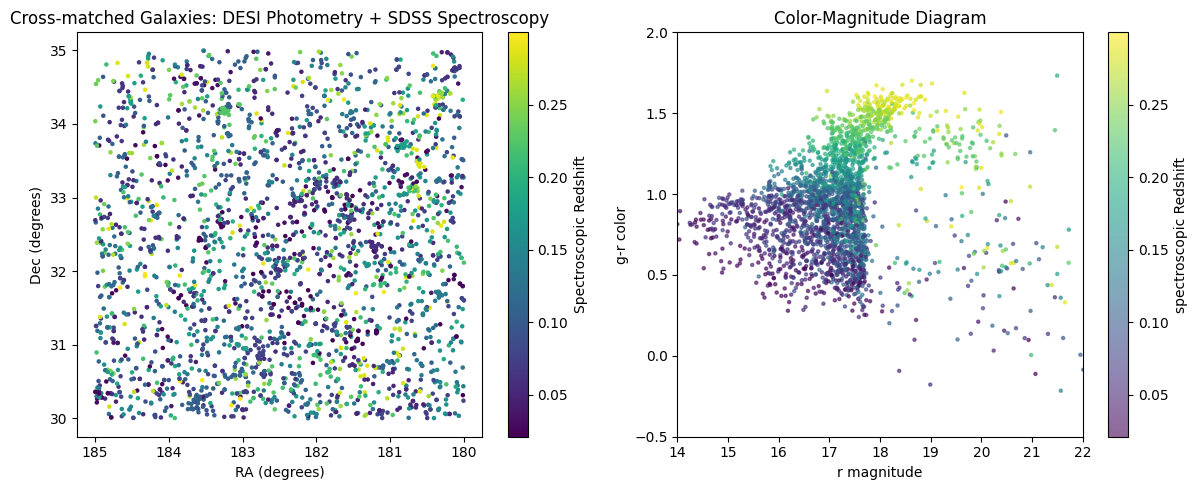

In [16]:
##############################################
#cross-matched data with photometry colors and spectroscopic redshifts
##############################################

plt.figure(figsize=(12, 5))

#the spatial distribution colored by redshift
plt.subplot(1, 2, 1)
plt.scatter(crossmatched_data['photo_ra'], crossmatched_data['photo_dec'],s=5, c=crossmatched_data['redshift'], cmap='viridis')
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('Cross-matched Galaxies: DESI Photometry + SDSS Spectroscopy')
plt.colorbar(label='Spectroscopic Redshift')
plt.gca().invert_xaxis()




# Right panel: Color-magnitude diagram
plt.subplot(1, 2, 2)
plt.scatter(crossmatched_data['mag_r'],
           crossmatched_data['g_r'],
           c=crossmatched_data['redshift'],
           s=5,
           alpha=0.6,
           cmap='viridis')
plt.xlabel('r magnitude')
plt.ylabel('g-r color')
plt.title('Color-Magnitude Diagram')
plt.colorbar(label='spectroscopic Redshift')
plt.xlim(14, 22)
plt.ylim(-0.5, 2.0)
plt.tight_layout()
plt.show()

In [17]:
#this is cool bc we get to see if the properties of the  galaxies change with distance

In [18]:
#next: 1) we need to select the redshift slices for large-scale structure
#2)3d view of the cosmic web
#3) analyze clustering in redshift slice
#4)add cosmic slime matter density

In [3]:

def zSlicePlot(zMin, zMax, data, raMin=ra_min, raMax = ra_max, decMin = dec_min, decMax = dec_max,):
    '''A function to plot a z slice with given limits.
    INPUTS:
        zMin (float): the minimum z-value of the slice
        zMax (float): the maximum z-value of the slice
        data (array-like): the table of data to use.
        raMin (float): the minimum ra of the area to display. Default is ra_min
        raMax (float): the maximum ra of the area to display. Default is ra_max
        decMin (float): the minimum dec of the area to display. Default is dec_min
        decMax (float): the maximum dec of the area to display. Default is dec_max
    Produces a mathplot scatterplot of the desired region, with galaxies in the z-slice in black, and others in pale red.
    '''
    rz = (data['z'] >zMin) & (data['z']<zMax)
    plt.axis([raMin,raMax,decMin,decMax])
    plt.xlabel("RA (degrees)", fontsize=20)
    plt.ylabel("Dec (degrees)", fontsize=20)
    plt.scatter(data['ra'], data['dec'],s=3,color='r',marker='o',alpha=0.25)
    plt.scatter(data['ra'][rz], data['dec'][rz],s=10,color='b',marker='o')
    plt.show()

In [ ]:
#Jenna's attempts to make astroquery work
query_photo = f'''
SELECT
    pz.z,
    pz.zErr,
    photo.dec,
    photo.ra,
    photo.objID
FROM  PhotoObj AS photo
JOIN Photoz AS pz ON photo.ObjID = pz.ObjID
WHERE
    photo.ra BETWEEN {ra_min} AND {ra_max}
    AND photo.dec BETWEEN {dec_min} AND {dec_max}
    AND pz.z BETWEEN {z_min} AND {z_max}
    AND photo.type = 3
    AND pz.zERR >= 0
    AND photo.clean = 1
    AND pz.PhotoErrorClass = 1
'''
photo_data = SDSS.query_sql(query_photo,timeout=600)


In [9]:
query_spec = f"""
SELECT
    s.ra,
    s.dec,
    s.z,
    s.zerr,
    s.class,
    s.specobjid,
    s.bestobjid
FROM specobj AS s
WHERE
    s.ra BETWEEN {ra_min} AND {ra_max}
    AND s.dec BETWEEN {dec_min} AND {dec_max}
    AND s.z BETWEEN {z_min} AND {z_max}
    AND s.class = 'GALAXY'
    AND s.zwarning = 0
"""
spec_data = SDSS.query_sql(query_spec,timeout=600)


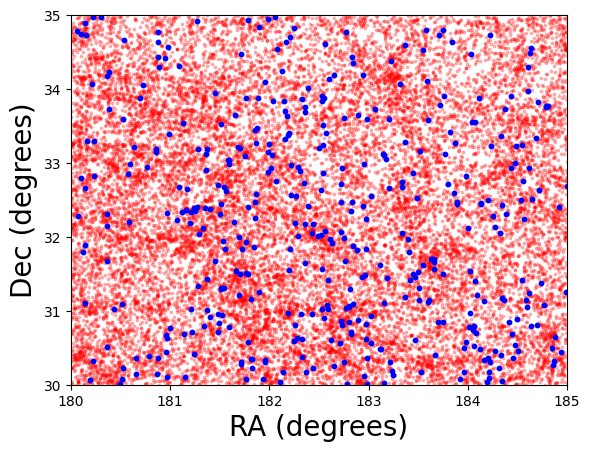

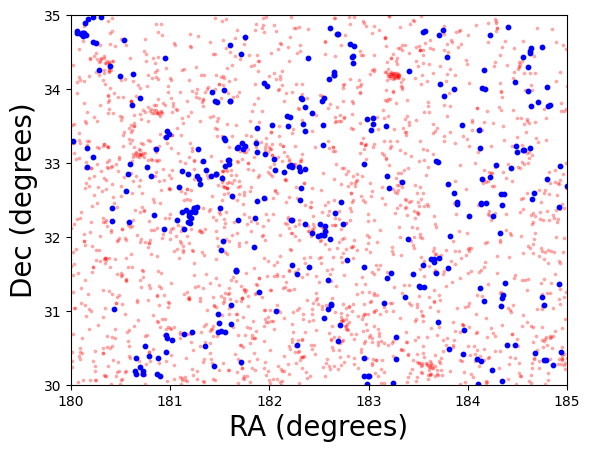

In [10]:
zSlicePlot(0.05,0.07, data=photo_data)
zSlicePlot(0.05,0.07, data=spec_data)

In [11]:
PhotoZ_std = np.std(photo_data['z'])
SpecZ_std = np.std(spec_data['z'])
print(f"Photometric redshift standard deviation: {PhotoZ_std:.3f}")
print(f"Spectroscopic redshift standard deviation: {SpecZ_std:.3f}")

PhotoZ_meanErr = np.mean(photo_data['zErr'])
SpecZ_meanErr = np.mean(spec_data['zerr'])
print(f"Photometric redshift mean zErr: {PhotoZ_meanErr:.3e}")
print(f"Spectroscopic redshift mean zErr: {SpecZ_meanErr:.3e}")
'''
fig1, axes = plt.subplots(1,2, figsize=(15,5))

#Plot 1: Spectroscopic
axes[0].hist(spec_data['z'])
axes[0].hist(photo_data['z'], alpha=.25)
axes[0].set_title("Spectroscopic")
axes[0].set_xlabel("Redshift")
axes[0].set_ylabel("number of targets")

#Plot 2: Photometric
axes[1].hist(photo_data['z'])
axes[1].set_title("Photometric")
axes[1].set_xlabel("Redshift")
axes[1].set_ylabel("number of targets")

plt.show()'''

Photometric redshift standard deviation: 0.064
Spectroscopic redshift standard deviation: 0.073
Photometric redshift mean zErr: 5.291e-02
Spectroscopic redshift mean zErr: 2.400e-05


'\nfig1, axes = plt.subplots(1,2, figsize=(15,5))\n\n#Plot 1: Spectroscopic\naxes[0].hist(spec_data[\'z\'])\naxes[0].hist(photo_data[\'z\'], alpha=.25)\naxes[0].set_title("Spectroscopic")\naxes[0].set_xlabel("Redshift")\naxes[0].set_ylabel("number of targets")\n\n#Plot 2: Photometric\naxes[1].hist(photo_data[\'z\'])\naxes[1].set_title("Photometric")\naxes[1].set_xlabel("Redshift")\naxes[1].set_ylabel("number of targets")\n\nplt.show()'

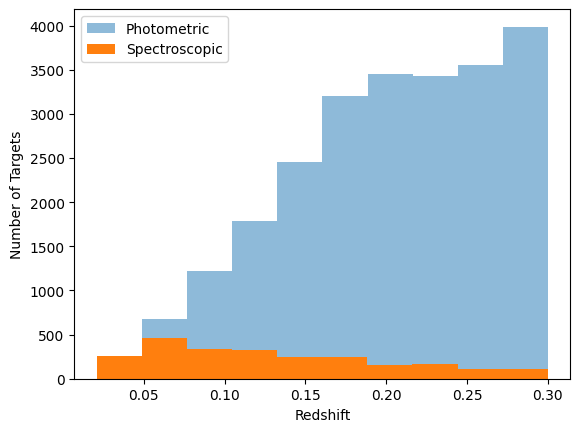

In [12]:
plt.hist(photo_data['z'], alpha=.50, label="Photometric")
plt.hist(spec_data['z'], label="Spectroscopic")
plt.xlabel("Redshift")
plt.ylabel("Number of Targets")
plt.legend(loc="upper left")
plt.show()

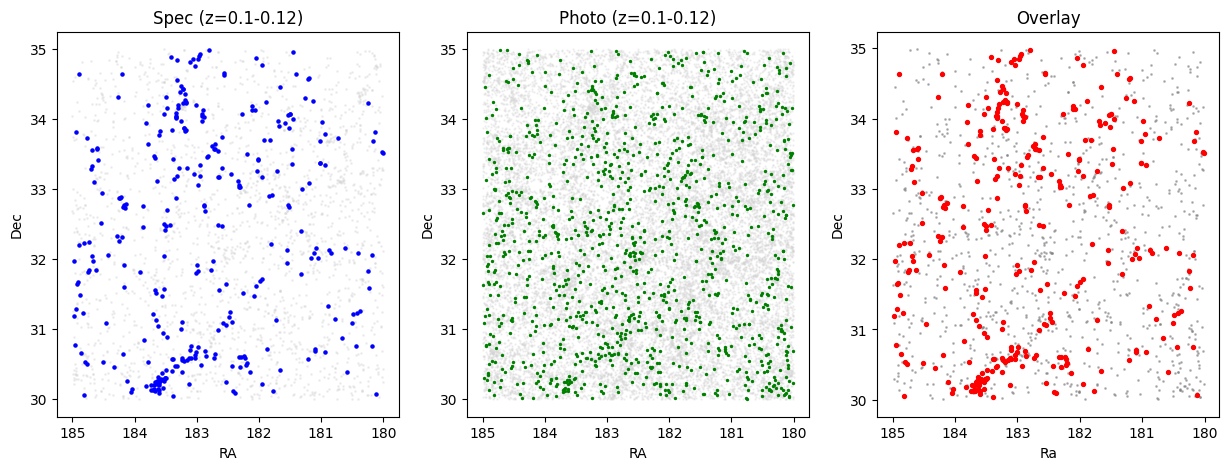

Redshift slice 0.1-0.12:
  Spec: 328 galaxies
  Photo: 1173 galaxies
  Ratio: 3.6x more photometric


In [13]:
# Modified version of your teammate's function for comparison
def compareSpecPhoto(zMin, zMax):
    """Compare spectroscopic and photometric samples in same redshift slice"""

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Filter for redshift slice
    spec_slice = (spec_data['z'] > zMin) & (spec_data['z'] < zMax)
    photo_slice = (photo_data['z'] > zMin) & (photo_data['z'] < zMax)

    # Plot 1: Spectroscopic
    axes[0].scatter(spec_data['ra'], spec_data['dec'], s=1, color='lightgray', alpha=0.3)
    axes[0].scatter(spec_data['ra'][spec_slice], spec_data['dec'][spec_slice], s=5, color='blue')
    axes[0].set_title(f'Spec (z={zMin}-{zMax})')
    axes[0].set_xlabel('RA')
    axes[0].set_ylabel('Dec')
    axes[0].invert_xaxis()

    # Plot 2: Photometric
    axes[1].scatter(photo_data['ra'], photo_data['dec'], s=0.5, color='lightgray', alpha=0.3)
    axes[1].scatter(photo_data['ra'][photo_slice], photo_data['dec'][photo_slice], s=2, color='green')
    axes[1].set_title(f'Photo (z={zMin}-{zMax})')
    axes[1].set_xlabel('RA')
    axes[1].set_ylabel('Dec')
    axes[1].invert_xaxis()

    # Plot 3: Overlay
    axes[2].scatter(photo_data['ra'][photo_slice], photo_data['dec'][photo_slice], s=1, color='gray', alpha=0.5)
    axes[2].scatter(spec_data['ra'][spec_slice], spec_data['dec'][spec_slice], s=8, color='red')
    axes[2].set_title('Overlay')
    axes[2].set_xlabel('Ra')
    axes[2].set_ylabel('Dec')
    axes[2].invert_xaxis()

    plt.show()

    # Printing the counts
    print(f"Redshift slice {zMin}-{zMax}:")
    print(f"  Spec: {spec_slice.sum()} galaxies")
    print(f"  Photo: {photo_slice.sum()} galaxies")
    print(f"  Ratio: {photo_slice.sum()/spec_slice.sum():.1f}x more photometric")

# Use it
compareSpecPhoto(0.10, 0.12)